In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip install --no-cache-dir -I pillow
!pip3 install unidecode
!pip install matplotlib==2.0.2

    100% |████████████████████████████████| 2.0MB 34.7MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils,datasets
from tqdm import tqdm
from torch import autograd
from torch.autograd import Variable

assert torch.cuda.is_available() #make sure you have changed the runtime type from Runtime tab

from torch.nn.parameter import Parameter
import pdb
import torch.nn.init as init
import torchvision
import os
import gzip
import tarfile
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
import torchvision.models as models

In [ ]:
!wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip
!unzip -q img_align_celeba
!mkdir test
!mv img_align_celeba test

In [ ]:

class CelebaDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebaDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    return img[0]

  def __len__(self):
    return len(self.dataset_folder)



In [ ]:

G_input_dim= 100
G_output_dim=3
D_input_dim= 3
D_output_dim=1
batch_size= 128
num_filters=[1024, 512, 256, 128]
nf=[128,256,512,1024]
num_epochs= 25

train_dataset=CelebaDataset('./test')
train_loader= DataLoader(train_dataset, batch_size=128,pin_memory=True, shuffle= True)

def denorm(x):
  out= (x+1)/2
  return out.clamp(0,1)

In [ ]:
class Generator(torch.nn.Module):
  def __init__(self, input_dim, num_filters, output_dim):
    super(Generator, self).__init__()
    self.hidden_layer= torch.nn.Sequential()
    for i in range(len(num_filters)):
      if i==0:
        deconv= torch.nn.ConvTranspose2d(input_dim, num_filters[i], kernel_size= 4, stride=1, padding= 0)
      else:
        deconv= torch.nn.ConvTranspose2d(num_filters[i-1],num_filters[i], kernel_size= 4, stride=2, padding=1)
      deconv_name= 'deconv'+ str(i-1)
      self.hidden_layer.add_module(deconv_name, deconv)
      torch.nn.init.normal(deconv.weight, mean= 0.0, std= 0.02)
      torch.nn.init.constant(deconv.bias,  0.0)
      act_name= 'act'+ str(i-1)
      self.hidden_layer.add_module(act_name, torch.nn.ReLU())

    self.output_layer= torch.nn.Sequential()
    out= torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size= 4, stride=2, padding= 1)
    self.output_layer.add_module('out', out)
    torch.nn.init.normal(out.weight, mean= 0.0, std=0.02)
    torch.nn.init.constant(out.bias, 0.0)

    self.output_layer.add_module('act',torch.nn.Tanh())

  def forward(self,x):
    h= self.hidden_layer(x)
    out= self.output_layer(h)
    return out

#discriminator model

class Discriminator(torch.nn.Module):
  def __init__(self, input_dim, num_filters, output_dim):
    super(Discriminator, self).__init__()
    self.hidden_layer= torch.nn.Sequential()
    for i in range(len(num_filters)):
      if i==0:
        conv= torch.nn.Conv2d(input_dim, num_filters[i], kernel_size= 4, stride=2, padding= 1)

      else:
        conv= torch.nn.Conv2d(num_filters[i-1],num_filters[i], kernel_size= 4, stride=2, padding= 1)

      conv_name= 'conv'+ str(i-1)
      self.hidden_layer.add_module(conv_name, conv)
      torch.nn.init.normal(conv.weight, mean= 0.0, std= 0.02)
      torch.nn.init.constant(conv.bias,  0.0)
      act_name= 'act'+ str(i-1)
      self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

    self.output_layer= torch.nn.Sequential()
    out= torch.nn.Conv2d(num_filters[i], output_dim, kernel_size= 4, stride=1, padding= 0)
    self.output_layer.add_module('out', out)
    torch.nn.init.normal(out.weight, mean= 0.0, std=0.02)
    torch.nn.init.constant(out.bias, 0.0)
    self.output_layer.add_module('act',torch.nn.Sigmoid())

  def forward(self,x):
    h= self.hidden_layer(x)
    out= self.output_layer(h)
    return out


G= Generator(G_input_dim, num_filters, G_output_dim).cuda()
D= Discriminator(D_input_dim, nf, D_output_dim).cuda()
criterion= torch.nn.BCELoss()
G_optim= torch.optim.Adam(G.parameters(), lr= 0.0002, betas= (0.5,0.999))
D_optim= torch.optim.Adam(D.parameters(), lr= 0.0002, betas= (0.5,0.999))


#fixed noise
num_test_samples= 5*5
noise= torch.randn(num_test_samples, G_input_dim).view(-1, G_input_dim,1,1)

for epoch in range(num_epochs):

  for images in (train_loader):
    batch_size_= images.size()[0]
    x= Variable(images.cuda())

    y_real=Variable(torch.ones(batch_size_).cuda())
    y_fake= Variable(torch.zeros(batch_size_).cuda())

    #train discriminator with real data
    D_real_out= D(x).squeeze()
    D_real_loss= criterion(D_real_out, y_real)

    #train discriminator with fake data
    z= torch.randn(batch_size_, G_input_dim).view(-1, G_input_dim,1,1)
    z= Variable(z.cuda())
    gen_image= G(z)

    D_fake_out= D(gen_image).squeeze()
    D_fake_loss= criterion(D_fake_out, y_fake)

    #back propagation
    D_loss= D_real_loss + D_fake_loss
    D.zero_grad()
    D_loss.backward()
    D_optim.step()

    #train generator
    z= torch.randn(batch_size_, G_input_dim).view(-1, G_input_dim,1,1)
    z= Variable(z.cuda())
    gen_image= G(z)

    D_fake_out= D(gen_image).squeeze()
    G_loss= criterion(D_fake_out, y_real)

    #backpropagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optim.step()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


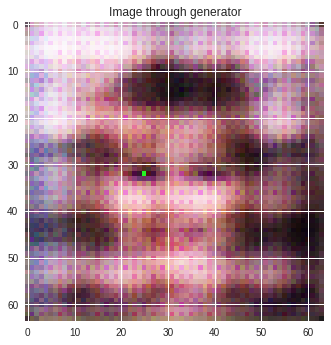

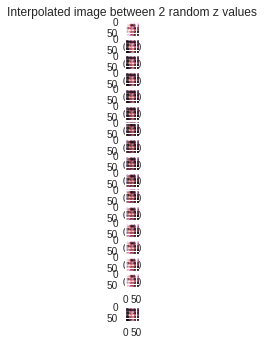

In [ ]:
def plot_graph(gen1,noise):
  noisev = autograd.Variable(noise, volatile=True)
  gen1.eval()
  samples = gen1(noisev.cuda())
  samples=samples[10]
  samples=samples.cpu().data.numpy().transpose(1,2,0)
  return samples

num_test_samples= 5*5
randomz=torch.randn(num_test_samples, G_input_dim).view(-1, G_input_dim,1,1)
samples=plot_graph(G,randomz)
plt.imshow(samples)
plt.title('Image through generator')
plt.show()
random_z1 = torch.randn(num_test_samples, G_input_dim).view(-1, G_input_dim,1,1)
random_z2 = torch.randn(num_test_samples, G_input_dim).view(-1, G_input_dim,1,1)
s = plot_graph(G,random_z1)
plt.subplot(18,1,1)
plt.imshow(s)
plt.title('Interpolated image between 2 random z values')
for i in range(15):
  interpolated_z = random_z1*i/15 + random_z2*(1 - i/15)
  s = plot_graph(G,interpolated_z)
  plt.subplot(18,1,i+2)
  plt.imshow(s)
s = plot_graph(G,random_z2)
plt.subplot(18,1,18)
plt.imshow(s)